
<h1>
<center></center>
</h1>





<h1>
<center>Trading Strategy - SPY Price Prediction Based on Regressors</center>
</h1>

<h1>
<center>Ian Lee</center>
</h1>

# Introduction

**Propose**

In this project, the goal is to predict the closing price of the SPY ETF, which tracks the S&P 500, a key indicator of the US stock market. Machine learning methods, specifically random forest regression, and linear regression, are used. By making accurate predictions, it is possible to decide whether to take long or short positions on the SPY, enabling the implementation of this trading strategy in the equity market.



**Summary**

Assumption:
It is assumed that the SPY ETF reflects the S&P 500, so variables related to the US stock market can be used as feature variables to efficiently predict the SPY closing price.

Hypothesis Test:
The hypothesis of this trading strategy is that the feature variable has a significant effect on predicting the target variable (the closing price of SPY). To validate this hypothesis, P-value and correlation tests will be used to determine if the assumption is strong enough to deploy this trading strategy.

Indicator:
To evaluate whether the model provides better predictions, the mean squared error (MSE) is used as an indicator. Specifically, the MSE of the model is compared to the MSE of a simple prediction method, where the predicted price is assumed to be equal to the previous price. In this simple prediction method, the price at t=1 is assumed to be the same as the price at t=0, which is already known. If the MSE of the model is lower than that of the simple prediction, the model is considered to have better predictive performance.

Signal Process and Rule:
The linear regression model is used to determine the p-value of each variable. If the p-value is small (less than 0.1), it indicates that the variable is significant for the prediction. Additionally, a simple correlation analysis is performed; if the absolute value of the correlation is higher than 0.5, the variable is considered for use in the model.





**Strategy**

Objectives of Strategy:
The strategy aims to use feature variables to make daily predictions of the SPY ETF closing price. Based on these predictions, long or short positions are taken, and then closed within the same day to generate returns. This process is repeated daily with the goal of accurately predicting market directions (long or short) to consistently make a profit.

Constraints:
Positions are limited to daily trades, meaning no positions are held overnight. This approach simplifies the model, making it easier to build, monitor, and modify, and it also reduces some transaction costs. For example, taking short positions incurs borrowing costs, which are difficult to approximate during backtesting. Additionally, positions are closed when the price reaches the predicted level. While this might potentially reduce profits, it also mitigates drawdown risk. For instance, if the predicted price is 96, the open price is 95, the highest price of the day is 97, but it quickly drops and closes at 92, this constraint ensures a profit when the price declines.

Benchmarks:
The SPY itself serves as the benchmark since it represents investing in the US equity market. The benchmark return is calculated by holding a long position at the beginning of the day, when our trading strategy is deployed in backtesting, and closing it (selling it) at the end of the day, when our trading strategy is not used in backtesting. The performance of our trading strategy is evaluated by comparing its annualized return, volatility, and Sharpe ratio against this benchmark.

**Data**

In this project, the variables used are the SPY's closing price, trading volume, and the yield rate of the ten-year Treasury bond, which is considered the risk-free rate of the market and is widely used in financial models as a fundamental element. The yield rate shows the current risk-free return from the market, representing the basic return for investments. Therefore, it is an important indicator for measuring the US equity market, which is correlated with the SPY.

# Hypothesis Testing

**Concept**


In hypothesis testing, linear regression and correlation tests are conducted to determine if the potential feature variables have a correlation with the target variable (the daily closing price of SPY).

**Data Process**


Download financial data individually from the Yahoo Finance API, fill in any missing data with the mean, and finally organize it into a DataFrame.

In [ ]:
# Import packages
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, DayLocator
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [ ]:
# Download the daily price data for SPY
spy_data = yf.download('SPY', start='1900-01-01', end='2024-12-31', interval='1d')
risk_free_data=yf.download("^TNX", start='1900-01-01', end='2024-12-31', interval='1d')
SP500_data=yf.download("^GSPC", start='1900-01-01', end='2024-12-31', interval='1d')

# Meaure time as index
spy_data.index = pd.to_datetime(spy_data.index)
risk_free_data.index = pd.to_datetime(risk_free_data.index)
SP500_data.index = pd.to_datetime(SP500_data.index)

# Select the 'Close' column from risk_free_data and rename it
risk_free_data_close = risk_free_data[['Close']].rename(columns={'Close': 'Risk_Free_Close'})
SP500_data_close = SP500_data[['Close']].rename(columns={'Close': 'SP500_Close'})

# Merge the dataframes on the index (Date)
combined_df = pd.merge(spy_data, risk_free_data_close/100, left_index=True, right_index=True, how='left')
combined_df = pd.merge(combined_df , SP500_data_close, left_index=True, right_index=True, how='left')

# Fill NaN value in risk free rate data set
def fill_na_with_avg(series):
    for i in range(1, len(series) - 1):
        if pd.isna(series[i]):
            series[i] = (series[i - 1] + series[i + 1]) / 2
    return series

combined_df['Risk_Free_Close'] = fill_na_with_avg(combined_df['Risk_Free_Close'].values)

# Display the combined dataframe
combined_df

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Risk_Free_Close,SP500_Close
Date,,,,,,,,
1993-01-29,43.968750,43.968750,43.750000,43.937500,24.763739,1003200,0.06390,438.779999
1993-02-01,43.968750,44.250000,43.968750,44.250000,24.939867,480500,0.06380,442.519989
1993-02-02,44.218750,44.375000,44.125000,44.343750,24.992710,201300,0.06460,442.549988
1993-02-03,44.406250,44.843750,44.375000,44.812500,25.256897,529400,0.06450,447.200012
1993-02-04,44.968750,45.093750,44.468750,45.000000,25.362576,531500,0.06390,449.559998
...,...,...,...,...,...,...,...,...
2024-05-20,529.570007,531.559998,529.169983,530.059998,530.059998,37764200,0.04437,5308.129883
2024-05-21,529.280029,531.520020,529.070007,531.359985,531.359985,33437000,0.04414,5321.410156
2024-05-22,530.650024,531.380005,527.599976,529.830017,529.830017,48390000,0.04434,5307.009766


**Fundamental Assumption Test**

In this test, linear regression is used to determine if SPY is highly related to the S&P 500 index. The results below indicate a high correlation between them, thus confirming the basic assumption.

In [ ]:
# Fit linear regression model
model = sm.OLS(combined_df['Close'], combined_df['SP500_Close']).fit()
# View model summary
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Close   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.524e+09
Date:                Sun, 26 May 2024   Prob (F-statistic):                        0.00
Time:                        17:41:38   Log-Likelihood:                         -5281.9
No. Observations:                7887   AIC:                                  1.057e+04
Df Residuals:                    7886   BIC:                                  1.057e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

**Feature Variable Test**


In this test, linear regression is used to determine if the feature variables are highly related to the SPY closing price. The results below indicate that the previous day's closing price and the risk-free rate have a high correlation with the SPY closing price. However, the volume may not be significant for the prediction. Correlation analysis was also performed, confirming the results of the linear regression. Therefore, the use of volume is eliminated from the models.

In [ ]:
# Shift the 'Close' column by one period to use it as a feature
combined_df['Close_Shifted'] = combined_df['Close'].shift(1)

# Drop rows with NaN values created by the shift
combined_df = combined_df.dropna()

# Create x and y
x = combined_df[['Close_Shifted', 'Volume', 'Risk_Free_Close']].values
y = combined_df['Close'].values

# Ensure matching lengths
print(f"x shape: {x.shape}")
print(f"y shape: {y.shape}")

# Fit linear regression model
model = sm.OLS(y, x).fit()

# View model summary
print(model.summary())

x shape: (7886, 3)
y shape: (7886,)
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          2.186e+07
Date:                Sun, 26 May 2024   Prob (F-statistic):                        0.00
Time:                        17:41:42   Log-Likelihood:                         -17683.
No. Observations:                7886   AIC:                                  3.537e+04
Df Residuals:                    7883   BIC:                                  3.539e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----

In [ ]:
# Caculate and print the correlation
print("Correlation with itself:",np.corrcoef(combined_df['Close'],combined_df['Close'])[0,1])
print("Correlation with Volume:",np.corrcoef(combined_df['Close'],combined_df['Volume'])[0,1])
print("Correlation with Risk Free Rate:",np.corrcoef(combined_df['Close'],combined_df['Risk_Free_Close'])[0,1])

Correlation with itself: 1.0
Correlation with Volume: 0.0762568947305569
Correlation with Risk Free Rate: -0.5665547460182592


**Summary**

Based on the results of the linear regression and correlation analysis, it is evident that volume may not be a suitable feature variable. In contrast, SPY and the risk-free rate appear to be strong feature variables. Therefore, for the models intended to be built, only SPY and the risk-free rate will be used as feature variables (parameters).

# Regressors - Random Forest Regression



**Concept**

In this model, a function is created to select the best hyperparameters by evaluating the MSE of the validation set after training the model on the training set. Ultimately, this function measures the accuracy on the test set.






**Overfitting Issue**

By creating separate training, validation, and test sets, the issue of overfitting is avoided. The best hyperparameters are selected based on the performance on the validation set, which does not overlap with the test set. This ensures that the model is not overfitted to the test data.

In [ ]:
# Define data
data=combined_df
series_len = data["Close"].size
tscv = TimeSeriesSplit(n_splits=3)

# Hyperparamter combinations
ccp_alpha_list = [10**-1, 10**-3, 10**-5, 10**-7]
n_estimators_list = [200,400,600]

# Create function to do data spliting and testing
def time_series_valid_test(X, y, n_split, valid_or_test, optimal_par=None):
    tscv = TimeSeriesSplit(n_splits=n_split)
    rf_mse = []
    currentval_mse = []
    i = 0
    for train_index, test_index in tscv.split(X):
        i += 1
        # Break test set into 50% validation set, 50% test set
        break_test_ind = int(test_index[0] + 0.5*(test_index[-1]-test_index[0]))
        valid_index = np.array(list(range(test_index[0],break_test_ind)))
        test_index = np.array(list(range(break_test_ind,test_index[-1])))

        # Split
        X_train, X_valid, X_test = X[train_index], X[valid_index], X[test_index]
        y_train, y_valid, y_test = y[train_index], y[valid_index], y[test_index]

        # Tuning
        if valid_or_test == "valid":
            X_train_red, X_train_rest, y_train_red, y_test_red = train_test_split(
                X_train, y_train, test_size=0.1, random_state=42)
            for ccp_alpha in ccp_alpha_list:
                for n_estimators in n_estimators_list:
                    model_rf = RandomForestRegressor(random_state=42, n_jobs=-1,
                               ccp_alpha=ccp_alpha, n_estimators=n_estimators)
                    model_rf.fit(X_train_red, y_train_red.ravel())
                    y_val_rf = model_rf.predict(X_valid)
                    rf_mse.append(np.sqrt(mean_squared_error(y_valid, y_val_rf)))

        # Evalulate on test set
        if valid_or_test == "test":
            model_rf = RandomForestRegressor(random_state=42, n_jobs=-1,
                       ccp_alpha=optimal_par[0], n_estimators=optimal_par[1])
            model_rf.fit(X_train, y_train.ravel())
            y_test_rf = model_rf.predict(X_test)
            rf_mse.append(np.sqrt(mean_squared_error(y_test, y_test_rf)))

            # Predicting as next value as the current value
            y_test_currentval = y[test_index-1]
            currentval_mse.append(np.sqrt(mean_squared_error(y_test, y_test_currentval)))

            # Plot the prediction for the last CV fold
            if i == n_split:
                plt.figure(figsize=(10, 5))
                plt.plot(range(series_len-test_index.size,series_len),
                         y_test, "r--", label="Actual Close Price", )
                plt.plot(range(series_len-test_index.size,series_len),
                         y_test_rf, label="Predicted Close Price")
                plt.legend()

    # Average MSE over CV folds
    if valid_or_test == "valid":
        rf_mse = np.mean(np.array(rf_mse).reshape(
            n_split, len(ccp_alpha_list)*len(n_estimators_list)), axis=0)
        return rf_mse
    if valid_or_test == "test":
        rf_mse = np.mean(rf_mse)
        currentval_mse = np.mean(currentval_mse)

        #Returns: RF MSE, Current value prediction MSE, best fitted RF model
        return rf_mse, currentval_mse, model_rf


**Walk Forward Analysis**

In walk forward analysis, the model is tested on the validation set to find the best hyperparameters. The objective function is the minimum MSE, as increasing the accuracy of the prediction model is our primary goal. Therefore, reducing MSE is our primary objective. The results below show the best hyperparameters based on the MSE values.

In [ ]:
# Pick the best hyperparameters
rf_mse = time_series_valid_test(X, y, 3, "valid")
print(rf_mse)
ind = 0
for ccp_alpha in ccp_alpha_list:
        for n_estimators in n_estimators_list:
            if ind == np.argmin(rf_mse):
                optimal_par = [ccp_alpha, n_estimators]
                print(["(ccp_alpha, n_estimators):",[ccp_alpha, n_estimators]])
                print(rf_mse[ind])
            ind += 1

[21.82329091 21.82248169 21.81803559 20.07091098 20.07175151 20.08003959
 19.86797382 19.87423932 19.88185408 19.86242429 19.86791672 19.87561041]
['(ccp_alpha, n_estimators):', [1e-07, 200]]
19.862424285841215


**Plot**

In the plot, it is evident that the predicted closing price is highly inaccurate.

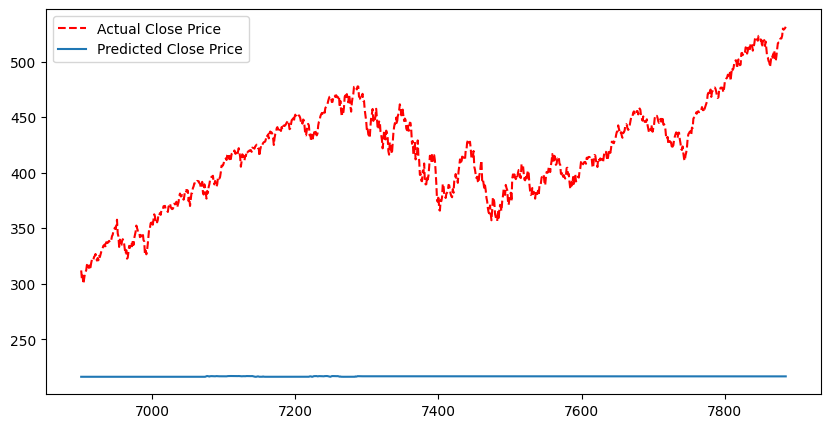

In [ ]:
# Results - plot
rf_mse, currentval_mse, model_rf = time_series_valid_test(X, y, 3, "test", optimal_par)

**MSE Evaluation**

The MSE of this model is approximately 35 times higher than the MSE of the simple prediction. This aligns with the results shown in the plot, confirming the model's poor performance.

In [ ]:
# Print MSE
print("Model MSE:",rf_mse)
print("Simple Prediction MSE:",currentval_mse)

Model MSE: 81.52448645786613
Simple Prediction MSE: 2.39306944987178


**Summary**

From the results, it can be inferred that the random forest regressor is not effective at predicting the SPY price, as indicated by the very high MSE and the inaccuracies shown in the plot. In future work, more hyperparameters could be optimized, and feature variables could be scaled to improve the accuracy of the predictions.



# Regressors - Linear Regression



**Concept**

Since the random forest regressor is not as efficient compared to the simple prediction, the focus shifted to improving the simple prediction model. While the simple prediction is accurate, it does not aid in developing a trading strategy. Assuming that tomorrow's closing price will be the same as today's can lead to certain losses when the market trend is upward. If the price rises tomorrow, the simple prediction (being the same as today's price) would trigger the model to short the stock, as the predicted price is lower than the open price.

The SPY price tends to have an upward trend due to its connection to the US economy, which experiences economic growth and inflation, causing prices to naturally rise in the long term. This results in certain losses with the simple prediction approach. Therefore, the goal is to improve the simple prediction model and reduce its MSE to be better or at least close to that of the simple prediction, thereby avoiding these certain losses.

**Optimization of Parameters**


In this process, walk-forward analysis is applied to optimize the parameters (feature variables) rather than the hyperparameters used in the function. Different observation periods (ranging from 1 day to 21 days) in the training set are compared to see how they affect the model's MSE in the validation set. The evaluation metric is the difference in MSE between the model and the simple prediction in the validation set, calculated as the simple prediction MSE minus the model MSE. The results indicate that a 3-day observation period has the best MSE, as it has the largest positive difference, demonstrating that the model performs better than the simple prediction in the validation set.

In [ ]:
# Find the best number of feature
data=combined_df
improvement_list=[]
for j in range(1,22):
  number_of_feature=j
  n=len(data['Close'])
  x=[]
  y=[]
  for i in range(n-number_of_feature):
    x.append(list(data['Close'].iloc[i:i+number_of_feature])+
             list(data['Risk_Free_Close'].iloc[i:i+number_of_feature]))
    y.append(data['Close'].iloc[i+number_of_feature])
  X=np.array(x)
  y=np.array(y)

  # Split data into different sets
  X_train, X_valid, X_test=X[:int(6*n/12)], X[int(6*n/12):int(9*n/12)], X[int(9*n/12):]
  y_train, y_valid, y_test=y[:int(6*n/12)], y[int(6*n/12):int(9*n/12)], y[int(9*n/12):]

  # Run linear Regression
  reg = LinearRegression().fit(X_train, y_train)
  pred=reg.predict(X_valid)

  #Calculate difference
  mse_improvement=mean_squared_error(y[int(6*n/12)-1:int(9*n/12)-1], y_valid)-mean_squared_error(pred, y_valid)
  improvement_list.append([j,mse_improvement])

# Show the difference of MSE in different choice of period
improvement_list

[[1, 0.0014141770939657405],
 [2, 0.00126756482268231],
 [3, 0.007839941454258703],
 [4, -0.0004988721115326555],
 [5, -0.003318482384119026],
 [6, -0.00034609443783395477],
 [7, -0.0041689719574753425],
 [8, -0.0058923482321966425],
 [9, -0.007986061350839346],
 [10, 0.00153962084546988],
 [11, 0.0005943155426719748],
 [12, -0.0019601074454640433],
 [13, -0.009828307699227157],
 [14, -0.01690316766733746],
 [15, -0.013307519980135574],
 [16, -0.03036293468072282],
 [17, -0.031888400171535825],
 [18, -0.03029233201229342],
 [19, -0.02781815298944368],
 [20, -0.029325337027809262],
 [21, -0.053619778866083934]]

**Plot**

The plot demonstrates how the 3-day period model performs in the test set. It is evident that this model's predictions are much closer to the actual closing prices compared to the random forest regressor.

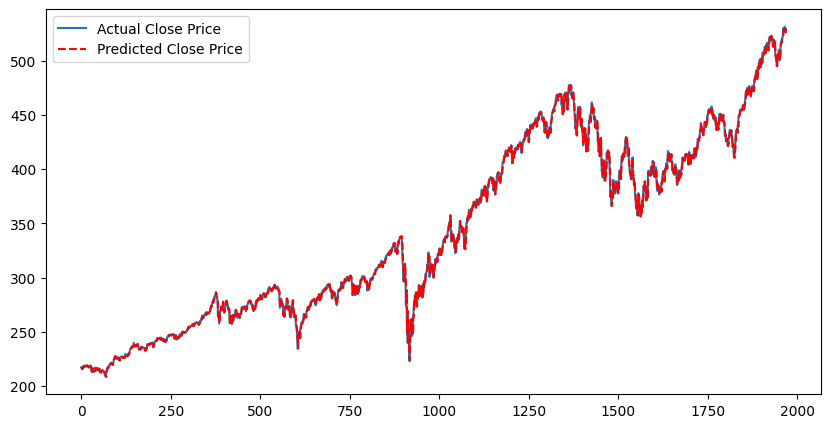

In [ ]:
#Choose 3 as the best number of feature
data=combined_df
number_of_feature=3
n=len(data['Close'])
x=[]
y=[]
for i in range(n-number_of_feature):
  x.append(list(data['Close'].iloc[i:i+number_of_feature])+
             list(data['Risk_Free_Close'].iloc[i:i+number_of_feature]))
  y.append(data['Close'].iloc[i+number_of_feature])
X=np.array(x)
y=np.array(y)

# Split data into different sets
X_train, X_valid, X_test=X[:int(6*n/12)], X[int(6*n/12):int(9*n/12)], X[int(9*n/12):]
y_train, y_valid, y_test=y[:int(6*n/12)], y[int(6*n/12):int(9*n/12)], y[int(9*n/12):]

# Run linear Regression
reg = LinearRegression().fit(X_train, y_train)
pred=reg.predict(X_test)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(y_test, label="Actual Close Price")
plt.plot(pred, "r--", label="Predicted Close Price")
plt.legend()

**MSE Evaluation**

The following MSE values show that while this model does not have a better MSE than the simple prediction model, it is very close to the MSE of the simple prediction model.

In [ ]:
# Print MSE
print("Model MSE:",mean_squared_error(pred, y_test))
print("Simple Prediction MSE:",mean_squared_error(y[int(9*n/12)-1:len(y)-1], y_test))

Model MSE: 15.293951170074202
Simple Prediction MSE: 15.15898054866974


**Summary**

From the plot and MSE values, it is evident that the model based on linear regression performs better than the random forest regressor. Additionally, its performance is close to that of the simple prediction model. Therefore, the linear regression model has been selected for use in the trading strategy.

# Backtesting

**Concept**

After selecting the model for our trading strategy, the next step is to deploy it. Backtesting is a crucial tool for evaluating the performance of the trading strategy, as it applies the strategy to historical data to assess its past performance. For detailed information on the trading strategy, please refer to the "Strategy" section in the Introduction.


**Training Period**


The length of the test set is chosen as the test period to help avoid overfitting, as the best model was not selected based on its performance on the test set. Furthermore, the training set does not include any data from the test set. The period for the test set spans from July 29, 2016, to May 24, 2024, constituting approximately one-third of the entire dataset.

In [ ]:
#Choose 3 as the best number of feature
data=combined_df
number_of_feature=3
n=len(data['Close'])
x=[]
y=[]
for i in range(n-number_of_feature):
  x.append(list(data['Close'].iloc[i:i+number_of_feature])+
             list(data['Risk_Free_Close'].iloc[i:i+number_of_feature]))
  y.append(data['Close'].iloc[i+number_of_feature])
X=np.array(x)
y=np.array(y)

# Split data into different sets
X_train, X_valid, X_test=X[:int(6*n/12)], X[int(6*n/12):int(9*n/12)], X[int(9*n/12):]
y_train, y_valid, y_test=y[:int(6*n/12)], y[int(6*n/12):int(9*n/12)], y[int(9*n/12):]

# Run linear Regression
reg = LinearRegression().fit(X_train, y_train)
pred=reg.predict(X_test)

**Trade Rules**



Based on these predictions, long or short positions are taken and then closed within the same day to generate returns. This process is repeated daily with the goal of accurately predicting market directions (long or short) to consistently make a profit.

Positions are limited to daily trades, meaning no positions are held overnight. This approach simplifies the model, making it easier to build, monitor, and modify, and it also reduces some transaction costs. Additionally, positions are closed when the price reaches the predicted level. If the price does not reach the predicted level, the position is still closed by the end of the day.


In [ ]:
# Update data
test_length=len(y_test)
open_prices=np.array(list(data['Open'].iloc[-test_length:]))
high_prices=np.array(list(data['High'].iloc[-test_length:]))
low_prices=np.array(list(data['Low'].iloc[-test_length:]))
action_series=[]
returns=[]

# Run through everyday trading data
for i in range(len(open_prices)):
  close_price=y_test[i]
  predict_price=pred[i]
  open_price=open_prices[i]
  high_price=high_prices[i]
  low_price=low_prices[i]

  # Condition of taking long position
  if predict_price>open_price:
    final_price=close_price
    # Set constraints of reaching the predicted price
    if predict_price<high_price:
      final_price=predict_price
    # Record dailly data: Open price, close price, Deal price, Predicted action, Return
    action_series.append([open_price,close_price,final_price,"Long",final_price/open_price-1])
    # Record returns individually (easier to calculate)
    returns.append(final_price/open_price)

  # Condition of taking long position
  elif predict_price<open_price:
    final_price=close_price
    # Set constraints of reaching the predicted price
    if predict_price>low_price:
      final_price=predict_price
    # Record dailly data: Open price, close price, Deal price, Predicted action, Return
    action_series.append([open_price,close_price,final_price,"Short",open_price/final_price-1])
    # Record returns individually (easier to calculate)
    returns.append(open_price/final_price)

  # Condition of taking hold position when open price is equal to predict price
  else:
    action_series.append([open_price,close_price,final_price,"Hold",0])
    returns.append(1)

**Plot**

This plot shows the open price and the predicted close price. It is evident that there is potential for profit by buying or selling at the open price and closing the position at the end of the day.

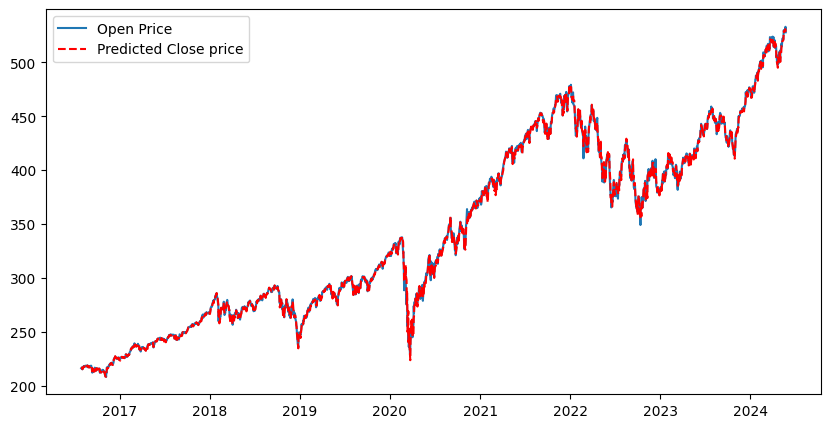

In [ ]:
# Plot
plt.figure(figsize=(10, 5))
plt.plot(data.index[-test_length:],np.array(list(data['Open'].iloc[-test_length:])), label="Open Price")
plt.plot(data.index[-test_length:],pred, "r--", label="Predicted Close price")
plt.legend()

**Table**

This table shows the daily trading details.

In [ ]:
# Display the trading strategy dataframe
df=pd.DataFrame(action_series)
df.columns=['Open price', 'Close price', 'Final price', 'Action', 'Return']
df.insert(0, "Date", data.index[-test_length:], True)
df

,Date,Open price,Close price,Final price,Action,Return
0,2016-07-29,216.460007,217.119995,216.713258,Long,0.001170
1,2016-08-01,217.190002,216.940002,217.063536,Short,0.000583
2,2016-08-02,216.649994,215.550003,215.550003,Long,-0.005077
3,2016-08-03,215.479996,216.179993,215.539231,Long,0.000275
4,2016-08-04,216.309998,216.410004,216.142362,Short,0.000776
...,...,...,...,...,...,...
1964,2024-05-20,529.570007,530.059998,530.059998,Short,-0.000924
1965,2024-05-21,529.280029,531.359985,529.468332,Long,0.000356
1966,2024-05-22,530.650024,529.830017,530.767462,Long,0.000221
1967,2024-05-23,532.960022,525.960022,529.332735,Short,0.006853


**Evaluation**

To evaluate the model's performance statistically, both the accuracy of the model in predicting the correct action and the average positive and negative returns are examined. The accuracy is approximately 70%, with an average positive return of 0.3% and an average negative return of -0.6%. Although it appears that losses are greater than gains, the 70% accuracy helps achieve a positive return overall. A simple calculation demonstrates this: 0.3% $\times$0.7 - 0.6% $\times$ 0.3 = 0.03%. The possible annualized return might be calculated as 0.03% $\times$ 252 = 7.56%

In [ ]:
# Calculate and print the accuracy of the model in guessing the correct action
right_decision = len([x for x in returns if x >= 1])/len(returns)

# Count the number of positive returns
positive_returns = df[df['Return'] > 0]
negative_returns = df[df['Return'] < 0]

# Print results
print("Average return:", np.mean(df['Return']))
print("Direction Accuracy:",right_decision)
print("Average positive return",np.mean(positive_returns['Return']))
print("Average negative return",np.mean(negative_returns['Return']))

Average return: 0.0002618505102566489
Direction Accuracy: 0.6866429659725749
Average positive return 0.003155496494973808
Average negative return -0.006053274107024923


**Performance**

The performance of the trading strategy is evaluated based on its annualized return, volatility, and Sharpe ratio. These metrics are then compared to the benchmark return, which is calculated by holding a long position at the beginning of the day (when our trading strategy is deployed in backtesting) and closing it at the end of the day (when our trading strategy is not used in backtesting).

As shown in the results below, although our trading strategy's annualized return is almost half of the benchmark's annualized return, its volatility is also nearly half of that of the benchmark strategy. The Sharpe ratio is almost equal between the two strategies. Therefore, there is a trade-off between taking volatility risk and achieving returns.

In [ ]:
# Calculate return, volatility and Sharpe ratio
total_return=np.prod(returns)
volatility=np.std(returns)*np.sqrt(252)
yearly_return=(np.prod(returns)**(1/len(returns)))**252-1
sharpe_ratio=yearly_return/volatility

# Print results
print("Total return:",total_return)
print("Annual return:",yearly_return)
print("Volatility:", volatility)
print("Sharpe ratio:",sharpe_ratio)

Total return: 1.610995484942795
Annual return: 0.06293010524350673
Volatility: 0.09939889245619678
Sharpe ratio: 0.6331067045967221


In [ ]:
# Calculate return, volatility and Sharpe ratio
actual_return=np.diff(y_test) / y_test[:-1]+1
total_return=np.prod(actual_return)
volatility=np.std(actual_return)*np.sqrt(252)
yearly_return=(np.prod(actual_return)**(1/len(actual_return)))**252-1
sharpe_ratio=yearly_return/volatility

# Print results
print("Total return:",total_return)
print("Annual return:",yearly_return)
print("Volatility:", volatility)
print("Sharpe ratio:",sharpe_ratio)

Total return: 2.438467273157616
Annual return: 0.12090769593146278
Volatility: 0.18390730851741635
Sharpe ratio: 0.6574382329129275


**Drawdown Risk**

Backtesting during drawdown periods provides deeper insights into the performance of the trading strategy under conditions of significant loss. This analysis helps determine whether the strategy is more risk-averse or more inclined to take on risk, offering valuable information for strategic adjustments.

**Drawdown Risk - 2018**

The return and volatility during the 2018 drawdown were tested to evaluate the performance of the trading strategy. The results indicate that this strategy effectively minimized losses during this period. The average daily return is close to zero, which is better than the benchmark, as the benchmark's return was negative during this period. Additionally, the strategy exhibited reduced volatility, a feature that may be favored by risk-averse investors.


In [ ]:
# Select period
drawdown_2018_df = df[(df['Date'] >= '2018-06-01') & (df['Date'] <= '2019-02-01')]

# Find the low and peak piont
low_point_index = drawdown_2018_df['Close price'].argmin()
peak_point_index = drawdown_2018_df['Close price'].argmax()

# Narrow the data based on the low and peak point
drawdown_2018_return=drawdown_2018_df.iloc[peak_point_index:low_point_index]
drawdown_2018_return

,Date,Open price,Close price,Final price,Action,Return
540,2018-09-20,292.640015,293.579987,293.579987,Short,-0.003202
541,2018-09-21,293.089996,291.989990,291.989990,Long,-0.003753
542,2018-09-24,291.339996,291.019989,291.019989,Long,-0.001098
543,2018-09-25,291.529999,290.750000,290.960429,Short,0.001958
544,2018-09-26,290.910004,289.880005,290.611552,Short,0.001027
...,...,...,...,...,...,...
600,2018-12-17,259.399994,255.360001,260.608968,Long,0.004661
601,2018-12-18,257.200012,255.080002,255.759634,Short,0.005632
602,2018-12-19,255.169998,251.259995,255.232743,Long,0.000246
603,2018-12-20,249.860001,247.169998,251.386379,Long,0.006109


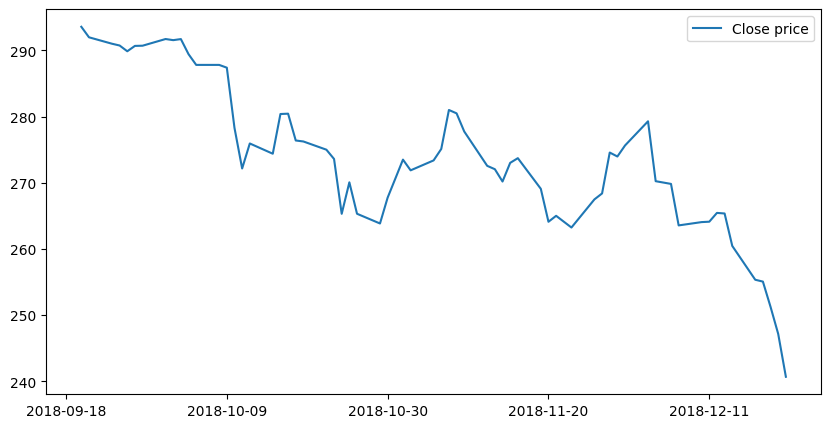

In [ ]:
# Plot the trend of close price
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(drawdown_2018_return['Date'],drawdown_2018_return['Close price'],label="Close price")
ax.xaxis.set_major_locator(DayLocator(interval=21))
plt.legend()

In [ ]:
# Calculate return, volatility and Sharpe ratio
returns=drawdown_2018_return['Return']+1
total_return=np.prod(returns)
volatility=np.std(returns)*np.sqrt(252)
yearly_return=(np.prod(returns)**(1/len(returns)))**252-1
sharpe_ratio=yearly_return/volatility

# Print results
print("Total return:",total_return)
print("Annual return:",yearly_return)
print("Volatility:", volatility)
print("Sharpe ratio:",sharpe_ratio)

Total return: 0.9911987689374891
Annual return: -0.033692081329734114
Volatility: 0.13773951339715923
Sharpe ratio: -0.2446072336017777


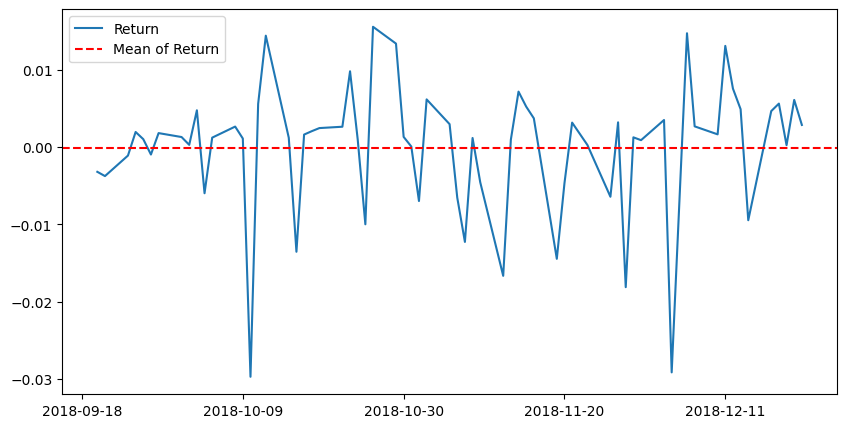

In [ ]:
# Plot the daily returns of the strategy
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(drawdown_2018_return['Date'],returns-1,label="Return")
mean_value = (returns-1).mean()
plt.axhline(mean_value, color='red', linestyle='--', label='Mean of Return')
ax.xaxis.set_major_locator(DayLocator(interval=21))
plt.legend()

In [ ]:
# Calculate return, volatility and Sharpe ratio
actual_return=np.diff(drawdown_2018_return['Close price']) / drawdown_2018_return['Close price'][:-1]+1
total_return=np.prod(actual_return)
volatility=np.std(actual_return)*np.sqrt(252)
yearly_return=(np.prod(actual_return)**(1/len(actual_return)))**252-1
sharpe_ratio=yearly_return/volatility

# Print results
print("Total return:",total_return)
print("Annual return:",yearly_return)
print("Volatility:", volatility)
print("Sharpe ratio:",sharpe_ratio)

Total return: 0.8198787654382332
Annual return: -0.5425019982020194
Volatility: 0.2029403295966093
Sharpe ratio: -2.673209407318729


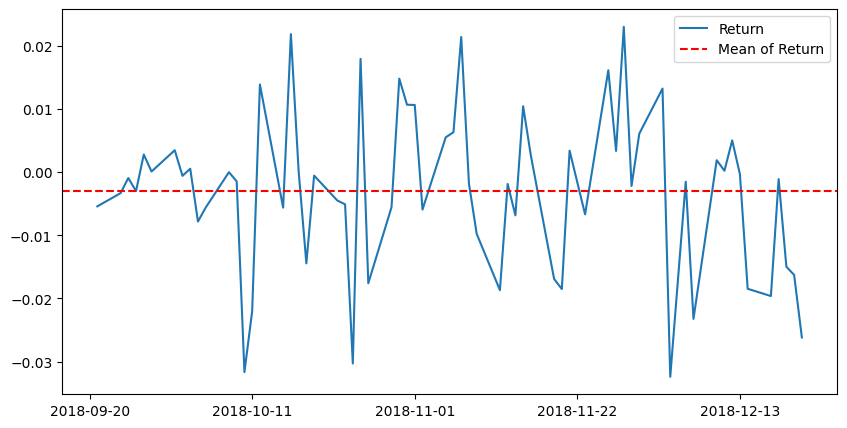

In [ ]:
# Plot the daily returns of benchmark
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(drawdown_2018_return['Date'][1:],actual_return-1,label="Return")
mean_value = (actual_return-1).mean()
plt.axhline(mean_value, color='red', linestyle='--', label='Mean of Return')
ax.xaxis.set_major_locator(DayLocator(interval=21))
plt.legend()

**Drawdown Risk - 2020**

The return and volatility during the 2020 drawdown were tested to evaluate the performance of the trading strategy. The results indicate that this strategy effectively minimized losses and even generated gains during this period. The average daily return was above zero, outperforming the benchmark, which had negative returns during the same period. Additionally, the strategy exhibited significantly reduced volatility, making it potentially more attractive to risk-averse investors.

In [ ]:
# Select period
drawdown_2020_df = df[(df['Date'] >= '2020-01-01') & (df['Date'] <= '2020-06-30')]

# Find the low and peak piont
low_point_index = drawdown_2020_df['Close price'].argmin()
peak_point_index = drawdown_2020_df['Close price'].argmax()

# Narrow the data based on the low and peak point
drawdown_2020_return=drawdown_2020_df.iloc[peak_point_index:low_point_index]

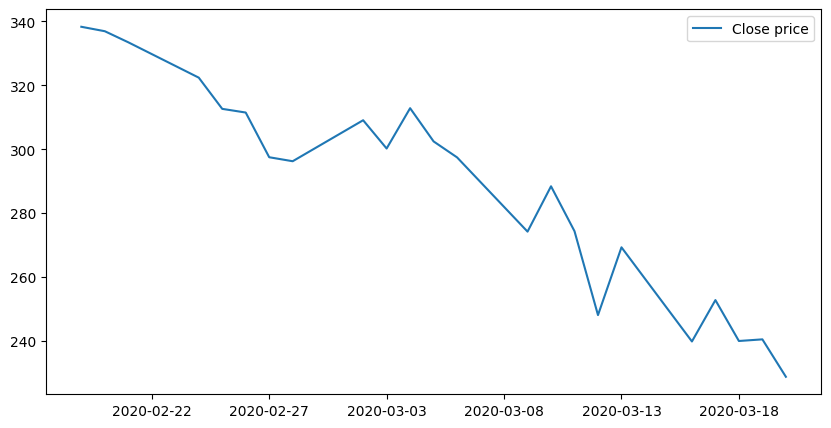

In [ ]:
# Plot the trend of close price
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(drawdown_2020_return['Date'],drawdown_2020_return['Close price'],label="Close price")
ax.xaxis.set_major_locator(DayLocator(interval=5))
plt.legend()

In [ ]:
# Calculate return, volatility and Sharpe ratio
returns=drawdown_2020_return['Return']+1
total_return=np.prod(returns)
volatility=np.std(returns)*np.sqrt(252)
yearly_return=(np.prod(returns)**(1/len(returns)))**252-1
sharpe_ratio=yearly_return/volatility

# Print results
print("Total return:",total_return)
print("Annual return:",yearly_return)
print("Volatility:", volatility)
print("Sharpe ratio:",sharpe_ratio)

Total return: 1.0507301056896863
Annual return: 0.7197627427369093
Volatility: 0.2957736975108201
Sharpe ratio: 2.433491378017407


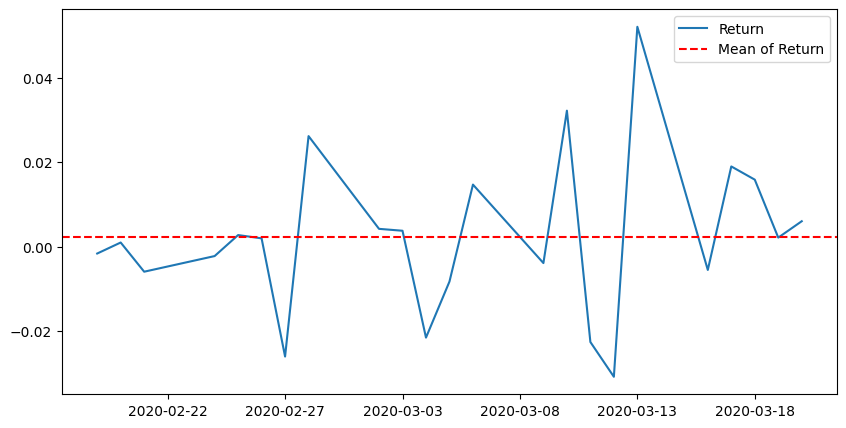

In [ ]:
# Plot the daily returns of the strategy
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(drawdown_2020_return['Date'],returns-1,label="Return")
mean_value = (returns-1).mean()
plt.axhline(mean_value, color='red', linestyle='--', label='Mean of Return')
ax.xaxis.set_major_locator(DayLocator(interval=5))
plt.legend()

In [ ]:
# Calculate return, volatility and Sharpe ratio
actual_return=np.diff(drawdown_2020_return['Close price']) / drawdown_2020_return['Close price'][:-1]+1
total_return=np.prod(actual_return)
volatility=np.std(actual_return)*np.sqrt(252)
yearly_return=(np.prod(actual_return)**(1/len(actual_return)))**252-1
sharpe_ratio=yearly_return/volatility

# Print results
print("Total return:",total_return)
print("Annual return:",yearly_return)
print("Volatility:", volatility)
print("Sharpe ratio:",sharpe_ratio)

Total return: 0.6762428489928272
Annual return: -0.9886785125340942
Volatility: 0.768255733778153
Sharpe ratio: -1.2869132881988903


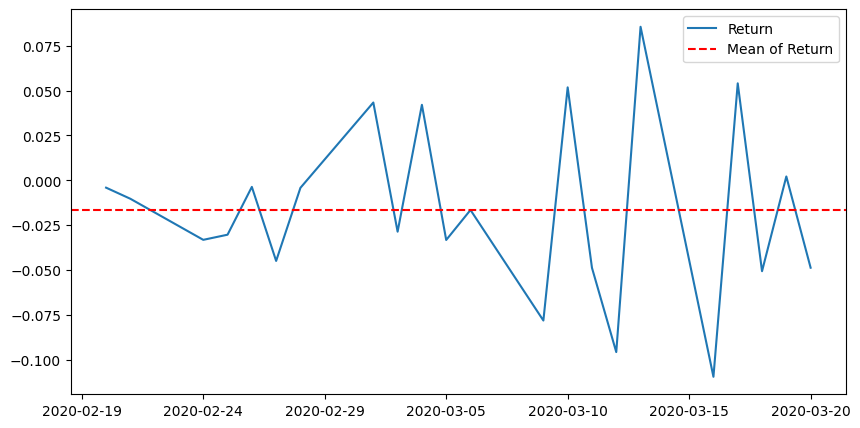

In [ ]:
# Plot the daily returns of benchmark
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(drawdown_2020_return['Date'][1:],actual_return-1,label="Return")
mean_value = (actual_return-1).mean()
plt.axhline(mean_value, color='red', linestyle='--', label='Mean of Return')
ax.xaxis.set_major_locator(DayLocator(interval=5))
plt.legend()

**Summary**

During the backtesting phase, our model demonstrated lower returns and reduced volatility compared to the benchmark strategy. Notably, during drawdown periods, the trading strategy experienced significantly smaller losses and, in some cases, even gains. These characteristics make it appealing to risk-averse investors.

However, compared to the benchmark trading strategy, the process of this trading strategy is much more complicated since it requires daily trades, whereas the benchmark strategy only involves buying and selling once, resulting in larger returns with a similar Sharpe ratio. Despite the increased trading frequency of the trading strategy, the benchmark strategy achieves larger returns than this trading strategy with a comparable Sharpe ratio. Consequently, this trading strategy does not provide a significant advantage in this context.


# Conclusion
In this project, the goal was to predict the closing price of the SPY ETF using machine learning methods, specifically random forest regression and linear regression. The analysis revealed that volume is not a significant feature variable, whereas SPY itself and the risk-free rate are effective predictors. The random forest regressor proved ineffective due to its high MSE and inaccuracies, while the linear regression model performed better and was comparable to the simple prediction model. Thus, the linear regression model was chosen for the trading strategy. During backtesting, the trading strategy demonstrated lower returns but reduced volatility. Additionally, it outperformed during drawdown periods, which may appeal to risk-averse investors. However, the model's complexity and requirement for daily trades, compared to the benchmark strategy's single buy-and-hold approach with higher returns and a similar Sharpe ratio, indicate that the trading strategy does not provide a significant advantage.

# Extension

**Concept**

The best model (linear regression) was applied to a bond ETF, considering that the Bond ETF might be highly correlated with the selected data. Bond ETFs are connected to bond yield rates and the broader equity market. Thus, the extended work involves applying the model to AGG, a widely traded Intermediate Core Bond ETF.

In [ ]:
# Download the daily price data for SPY
spy_data = yf.download('AGG', start='1900-01-01', end='2024-12-31', interval='1d')
risk_free_data=yf.download("^TNX", start='1900-01-01', end='2024-12-31', interval='1d')
SP500_data=yf.download("^GSPC", start='1900-01-01', end='2024-12-31', interval='1d')

# Meaure time as index
spy_data.index = pd.to_datetime(spy_data.index)
risk_free_data.index = pd.to_datetime(risk_free_data.index)
SP500_data.index = pd.to_datetime(SP500_data.index)

# Select the 'Close' column from risk_free_data and rename it
risk_free_data_close = risk_free_data[['Close']].rename(columns={'Close': 'Risk_Free_Close'})
SP500_data_close = SP500_data[['Close']].rename(columns={'Close': 'SP500_Close'})

# Merge the dataframes on the index (Date)
combined_df = pd.merge(spy_data, risk_free_data_close/100, left_index=True, right_index=True, how='left')
combined_df = pd.merge(combined_df , SP500_data_close, left_index=True, right_index=True, how='left')

# Fill NaN value in risk free rate data set
def fill_na_with_avg(series):
    for i in range(1, len(series) - 1):
        if pd.isna(series[i]):
            series[i] = (series[i - 1] + series[i + 1]) / 2
    return series

combined_df['Risk_Free_Close'] = fill_na_with_avg(combined_df['Risk_Free_Close'].values)

# Display the combined dataframe
combined_df

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Risk_Free_Close,SP500_Close
Date,,,,,,,,
2003-09-29,102.290001,102.300003,102.099998,102.169998,53.728966,13600,0.04077,1006.580017
2003-09-30,102.300003,102.739998,102.290001,102.699997,54.007694,62600,0.03937,995.969971
2003-10-01,102.639999,102.750000,102.599998,102.650002,53.981365,66300,0.03932,1018.219971
2003-10-02,102.199997,102.650002,102.010002,102.489998,53.897240,68900,0.04009,1020.239990
2003-10-03,102.050003,102.050003,101.699997,101.750000,53.508095,64500,0.04195,1029.849976
...,...,...,...,...,...,...,...,...
2024-05-20,96.709999,96.760002,96.669998,96.680000,96.680000,5263000,0.04437,5308.129883
2024-05-21,96.919998,96.949997,96.830002,96.860001,96.860001,5227900,0.04414,5321.410156
2024-05-22,96.660004,96.889999,96.650002,96.739998,96.739998,3823600,0.04434,5307.009766


**Hypothesis Testing**

The correlation and p-value of the feature variables were tested. The results suggest that all feature variables should be included in the prediction model.

In [ ]:
# Fit linear regression model
model = sm.OLS(combined_df['Close'], combined_df['Risk_Free_Close']).fit()
# View model summary
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Close   R-squared (uncentered):                   0.835
Model:                            OLS   Adj. R-squared (uncentered):              0.835
Method:                 Least Squares   F-statistic:                          2.633e+04
Date:                Sun, 26 May 2024   Prob (F-statistic):                        0.00
Time:                        22:47:14   Log-Likelihood:                         -26954.
No. Observations:                5200   AIC:                                  5.391e+04
Df Residuals:                    5199   BIC:                                  5.392e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

In [ ]:
# Shift the 'Close' column by one period to use it as a feature
combined_df['Close_Shifted'] = combined_df['Close'].shift(1)

# Drop rows with NaN values created by the shift
combined_df = combined_df.dropna()

# Create x and y
x = combined_df[['Close_Shifted', 'Risk_Free_Close', 'SP500_Close']].values
y = combined_df['Close'].values

# Ensure matching lengths
print(f"x shape: {x.shape}")
print(f"y shape: {y.shape}")

# Fit linear regression model
model = sm.OLS(y, x).fit()

# View model summary
print(model.summary())

x shape: (5196, 3)
y shape: (5196,)
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.650e+08
Date:                Sun, 26 May 2024   Prob (F-statistic):                        0.00
Time:                        22:49:22   Log-Likelihood:                         -1830.0
No. Observations:                5196   AIC:                                      3666.
Df Residuals:                    5193   BIC:                                      3686.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----

**Optimization of Parameters**

The results show that a 1-day observation period has the best MSE, as it has the smallest negative difference, indicating that the model performs worse than the simple prediction but is at least close in the validation set.

In [ ]:
# Find the best number of feature
data=combined_df
improvement_list=[]
for j in range(1,22):
  number_of_feature=j
  n=len(data['Close'])
  x=[]
  y=[]
  for i in range(n-number_of_feature):
    x.append(list(data['Close'].iloc[i:i+number_of_feature])+
             list(data['Risk_Free_Close'].iloc[i:i+number_of_feature])+
             list(data['SP500_Close'].iloc[i:i+number_of_feature]))
    y.append(data['Close'].iloc[i+number_of_feature])
  X=np.array(x)
  y=np.array(y)

  # Split data into different sets
  X_train, X_valid, X_test=X[:int(6*n/12)], X[int(6*n/12):int(9*n/12)], X[int(9*n/12):]
  y_train, y_valid, y_test=y[:int(6*n/12)], y[int(6*n/12):int(9*n/12)], y[int(9*n/12):]

  # Run linear Regression
  reg = LinearRegression().fit(X_train, y_train)
  pred=reg.predict(X_valid)

  #Calculate difference
  mse_improvement=mean_squared_error(y[int(6*n/12)-1:int(9*n/12)-1], y_valid)-mean_squared_error(pred, y_valid)
  improvement_list.append([j,mse_improvement])

# Show the difference of MSE in different choice of period
improvement_list

[[1, -0.0006496673476637793],
 [2, -0.008193268167364945],
 [3, -0.010640311996346213],
 [4, -0.011362403334546495],
 [5, -0.011434869154637678],
 [6, -0.011335491463138156],
 [7, -0.013044221949045712],
 [8, -0.013458780653933931],
 [9, -0.013816277837156977],
 [10, -0.014635962930874338],
 [11, -0.014520917920884717],
 [12, -0.01436609423687344],
 [13, -0.013981129493564948],
 [14, -0.014424398413392374],
 [15, -0.01506467833949389],
 [16, -0.015068914230096236],
 [17, -0.015114297022244247],
 [18, -0.015464788533669921],
 [19, -0.015545721000195474],
 [20, -0.015808114724759292],
 [21, -0.016041016397950622]]

**Training model**

The prediction is close to the actual future values, suggesting that if the prediction is accurate, the model could potentially generate profits even if the trend is downward.

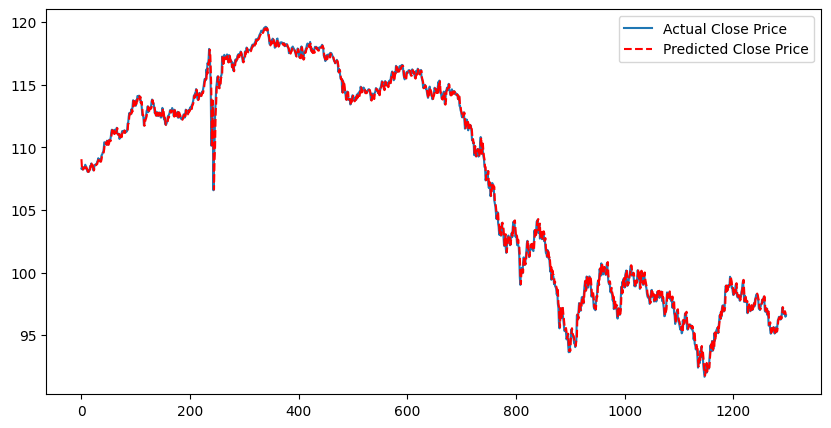

In [ ]:
#Choose 1 as the best number of feature
data=combined_df
number_of_feature=1
n=len(data['Close'])
x=[]
y=[]
for i in range(n-number_of_feature):
  x.append(list(data['Close'].iloc[i:i+number_of_feature])+
             list(data['Risk_Free_Close'].iloc[i:i+number_of_feature]))
  y.append(data['Close'].iloc[i+number_of_feature])
X=np.array(x)
y=np.array(y)

# Split data into different sets
X_train, X_valid, X_test=X[:int(6*n/12)], X[int(6*n/12):int(9*n/12)], X[int(9*n/12):]
y_train, y_valid, y_test=y[:int(6*n/12)], y[int(6*n/12):int(9*n/12)], y[int(9*n/12):]

# Run linear Regression
reg = LinearRegression().fit(X_train, y_train)
pred=reg.predict(X_test)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(y_test, label="Actual Close Price")
plt.plot(pred, "r--", label="Predicted Close Price")
plt.legend()

**Backtesting**

Backtesting is conducted to evaluate if the trading strategy performs better even when the trend is downward.

In [ ]:
# Update data
test_length=len(y_test)
open_prices=np.array(list(data['Open'].iloc[-test_length:]))
high_prices=np.array(list(data['High'].iloc[-test_length:]))
low_prices=np.array(list(data['Low'].iloc[-test_length:]))
action_series=[]
returns=[]

# Run through everyday trading data
for i in range(len(open_prices)):
  close_price=y_test[i]
  predict_price=pred[i]
  open_price=open_prices[i]
  high_price=high_prices[i]
  low_price=low_prices[i]

  # Condition of taking long position
  if predict_price>open_price:
    final_price=close_price
    # Set constraints of reaching the predicted price
    if predict_price<high_price:
      final_price=predict_price
    # Record dailly data: Open price, close price, Deal price, Predicted action, Return
    action_series.append([open_price,close_price,final_price,"Long",final_price/open_price-1])
    # Record returns individually (easier to calculate)
    returns.append(final_price/open_price)

  # Condition of taking long position
  elif predict_price<open_price:
    final_price=close_price
    # Set constraints of reaching the predicted price
    if predict_price>low_price:
      final_price=predict_price
    # Record dailly data: Open price, close price, Deal price, Predicted action, Return
    action_series.append([open_price,close_price,final_price,"Short",open_price/final_price-1])
    # Record returns individually (easier to calculate)
    returns.append(open_price/final_price)

  # Condition of taking hold position when open price is equal to predict price
  else:
    action_series.append([open_price,close_price,final_price,"Hold",0])
    returns.append(1)

In [ ]:
# Display the trading strategy dataframe
df=pd.DataFrame(action_series)
df.columns=['Open price', 'Close price', 'Final price', 'Action', 'Return']
df.insert(0, "Date", data.index[-test_length:], True)
df

,Date,Open price,Close price,Final price,Action,Return
0,2019-04-01,108.620003,108.309998,108.309998,Long,-0.002854
1,2019-04-02,108.389999,108.430000,108.430000,Short,-0.000369
2,2019-04-03,108.239998,108.230003,108.230003,Long,-0.000092
3,2019-04-04,108.250000,108.309998,108.219298,Short,0.000284
4,2019-04-05,108.269997,108.389999,108.298526,Long,0.000264
...,...,...,...,...,...,...
1293,2024-05-20,96.709999,96.680000,96.680000,Long,-0.000310
1294,2024-05-21,96.919998,96.860001,96.860001,Short,0.000619
1295,2024-05-22,96.660004,96.739998,96.739998,Long,0.000828
1296,2024-05-23,96.830002,96.470001,96.791981,Short,0.000393


**Evaluation**

Although this model's accuracy is not as high as the model applied to SPY, which might result in greater losses, the trading strategy incurs fewer losses than the benchmark trading strategy and exhibits lower volatility.

In [ ]:
# Calculate and print the accuracy of the model in guessing the correct action
right_decision = len([x for x in returns if x >= 1])/len(returns)

# Count the number of positive returns
positive_returns = df[df['Return'] > 0]
negative_returns = df[df['Return'] < 0]

# Print results
print("Average return:", np.mean(df['Return']))
print("Direction Accuracy:",right_decision)
print("Average positive return",np.mean(positive_returns['Return']))
print("Average negative return",np.mean(negative_returns['Return']))

Average return: -3.2895970058218226e-06
Direction Accuracy: 0.6055469953775039
Average positive return 0.0011776911869978413
Average negative return -0.0017817769572048678


In [ ]:
# Calculate return, volatility and Sharpe ratio
total_return=np.prod(returns)
volatility=np.std(returns)*np.sqrt(252)
yearly_return=(np.prod(returns)**(1/len(returns)))**252-1
sharpe_ratio=yearly_return/volatility

# Print results
print("Total return:",total_return)
print("Annual return:",yearly_return)
print("Volatility:", volatility)
print("Sharpe ratio:",sharpe_ratio)

Total return: 0.9928173917815163
Annual return: -0.0013985195319790034
Volatility: 0.03374331790012282
Sharpe ratio: -0.04144582154364592


In [ ]:
# Calculate return, volatility and Sharpe ratio
actual_return=np.diff(y_test) / y_test[:-1]+1
total_return=np.prod(actual_return)
volatility=np.std(actual_return)*np.sqrt(252)
yearly_return=(np.prod(actual_return)**(1/len(actual_return)))**252-1
sharpe_ratio=yearly_return/volatility

# Print results
print("Total return:",total_return)
print("Annual return:",yearly_return)
print("Volatility:", volatility)
print("Sharpe ratio:",sharpe_ratio)

Total return: 0.8916997877209507
Annual return: -0.022024987089710346
Volatility: 0.06602665216849894
Sharpe ratio: -0.33357722020348596


**Summary**

Using the Bond ETF provides more insight into the trading strategy, allowing us to examine its performance across different asset classes. This shows that while the trading strategy provides very low volatility, it also results in lower returns compared to the benchmark. The accuracy of this extended model is only 60%, indicating that accuracy plays a crucial role in the effectiveness of this linear trading model.

# Literature Review
The paper "Stock Market Prices Prediction using Random Forest and Extra Tree Regression" explores the application of machine learning algorithms, specifically Random Forest and Extra Tree Regressors, to predict stock market prices. The results indicate that Decision Tree and Random Forest Regressors outperform other models in terms of prediction accuracy. The study highlights the potential of using machine learning techniques for stock price prediction and suggests that these methods can handle large datasets efficiently, providing a robust tool for financial forecasting. It provides a view of using Random Forest in machine learning to predict closing price.

The paper "Stock Closing Price Prediction using Machine Learning Techniques" investigates the application of Artificial Neural Network (ANN) and Random Forest (RF) models to predict the closing prices of stocks. By utilizing financial data such as Open, High, Low, and Close prices, the researchers created new variables to enhance the predictive power of their models. Evaluated using Root Mean Square Error (RMSE) and Mean Absolute Percentage Error (MAPE), the results indicated that ANN outperformed RF in terms of prediction accuracy. The paper concludes that incorporating additional data sources, such as financial news, could further improve prediction accuracy, paving the way for more robust financial forecasting tools.

The paper "A Machine Learning Approach for Stock Price Prediction" by Carson Kai-Sang Leung, Richard Kyle MacKinnon, and Yang Wang explores the use of structural support vector machines (SSVMs) to predict stock price movements. By representing companies in the information technology sector as nodes in a graph structure and using an SSVM to classify these nodes, the study aims to determine whether stock prices will move up or down. Experimental results demonstrate the practicality and effectiveness of this machine learning method, achieving an accuracy rate higher than 78% on training data. It provides insight into the expected accuracy of the model.

"Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow" by Aurélien Géron is a comprehensive guide designed to introduce readers to machine learning and deep learning using popular Python frameworks. The book is divided into two main parts: the fundamentals of machine learning and neural networks, and deep learning. It covers a wide range of topics including data preprocessing, model selection, training, and evaluation. Through hands-on examples and practical exercises, the book helps readers to own the knowledge and tools to implement and deploy machine learning models effectively, which will be used in the project.



# Reference
Vijh, M., Chandola, D., Tikkiwal, V. A., & Kumar, A. (2020). Stock Closing Price Prediction using Machine Learning Techniques. Procedia Computer Science, 167, 599-606. https://doi.org/10.1016/j.procs.2020.03.326

Leung, C. K.-S., MacKinnon, R. K., & Wang, Y. (2014). A Machine Learning Approach for Stock Price Prediction. In Proceedings of the 18th International Database Engineering & Applications Symposium (IDEAS '14) (pp. 274-277). ACM. https://doi.org/10.1145/2628194.2628211

Polamuri, S. R., Srinivas, K., & Mohan, A. K. (2019). Stock Market Prices Prediction using Random Forest and Extra Tree Regression. International Journal of Recent Technology and Engineering (IJRTE), 8(3), 1224-1228. https://doi.org/10.35940/ijrte.C4314.098319

Géron, A. (2023). Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow (3rd ed.). O'Reilly Media.